In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
# Create example data
n_samples = 1000
x_temp = np.random.uniform(low=-10.0, high=40.0, size=n_samples)
x_sky = np.random.choice(['sunny', 'cloudy', 'rainy'], size=n_samples)
x_prec_prob = np.random.uniform(low=0.0, high=1.0, size=n_samples)
x_precip = np.random.uniform(low=0.0, high=10.0, size=n_samples)
x_humidity = np.random.uniform(low=0.0, high=100.0, size=n_samples)
x_wind_speed = np.random.uniform(low=0.0, high=20.0, size=n_samples)
y_solar_power = np.random.uniform(low=0.0, high=1000.0, size=n_samples)

# Normalize input variables
x_temp_norm = (x_temp - np.mean(x_temp)) / np.std(x_temp)
x_prec_prob_norm = (x_prec_prob - np.mean(x_prec_prob)) / np.std(x_prec_prob)
x_precip_norm = (x_precip - np.mean(x_precip)) / np.std(x_precip)
x_humidity_norm = (x_humidity - np.mean(x_humidity)) / np.std(x_humidity)
x_wind_speed_norm = (x_wind_speed - np.mean(x_wind_speed)) / np.std(x_wind_speed)
y_solar_norm = (y_solar_power - np.mean(y_solar_power) / np.std(y_solar_power))


In [3]:
y_tr = y_solar_norm[:700]
y_ts = y_solar_norm[700:]

In [5]:
sky = pd.DataFrame(x_sky)

In [6]:
sky = np.array(pd.get_dummies(sky).values)

In [15]:
x_data = np.concatenate([sky, x_temp_norm[:,np.newaxis], x_prec_prob_norm[:,np.newaxis], x_precip_norm[:,np.newaxis], x_humidity_norm[:,np.newaxis], x_wind_speed_norm[:,np.newaxis] ], axis = 1)

In [16]:
x_tr = x_data[:700]
x_ts = x_data[700:]

In [17]:
x_tr[:10]

array([[ 1.        ,  0.        ,  0.        ,  1.41959835, -0.64010601,
         1.4127912 ,  0.5802204 ,  0.10523961],
       [ 1.        ,  0.        ,  0.        , -0.50431756, -0.92944616,
        -1.38156956, -0.48261441, -0.87304571],
       [ 0.        ,  0.        ,  1.        , -0.71572758,  0.64977361,
         0.38655916, -1.66696222, -1.13626437],
       [ 0.        ,  0.        ,  1.        , -0.54728012,  1.30848949,
        -0.82120835,  0.77953283, -1.38222187],
       [ 0.        ,  1.        ,  0.        ,  1.06925165, -0.30072616,
         1.43065451, -1.63285795,  1.12415055],
       [ 0.        ,  0.        ,  1.        , -0.72505566, -0.24239218,
         0.40223123, -1.18280552, -0.52334018],
       [ 0.        ,  0.        ,  1.        ,  0.67396641, -1.75309387,
         1.64900744,  0.33106854,  0.90575912],
       [ 1.        ,  0.        ,  0.        , -0.23134613,  1.02400044,
         0.19002582,  1.25917928,  0.02494714],
       [ 0.        ,  1.        

In [18]:
# Define model architecture
inputs = layers.Input(shape=(8,))
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [19]:
# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=50, activation=tf.nn.tanh)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=50, activation=tf.nn.tanh)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

# Define the loss function
def custom_loss(model, inputs, outputs):
    # Calculate the gradients
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        predictions = model(inputs)
        loss = tf.reduce_mean(tf.square(predictions - outputs))

    grads = tape.gradient(loss, model.trainable_variables)

    # Define the boundary conditions
    boundary_x = tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])
    boundary_y = tf.constant([[0.0], [0.0]])

    # Calculate the boundary conditions
    predictions_boundary = model(boundary_x)
    loss_boundary = tf.reduce_mean(tf.square(predictions_boundary - boundary_y))

    # Return the loss function
    return loss + loss_boundary


In [20]:
# Define the input and output dimensions
input_dim = 8
output_dim = 1

# Create the PINN model
model = PINN(input_dim, output_dim)

# Define the optimizer and the learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Define the number of epochs
num_epochs = 5000

# Generate example data
x_train = np.random.rand(1000, 6)
y_train = np.sin(np.sum(x_train, axis=1)).reshape(-1, 1)

y_tr = y_tr.reshape(-1,1)
x_train = tf.convert_to_tensor(x_tr, dtype=tf.float32)
# Train the PINN model
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        loss = custom_loss(model, x_train, y_tr)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 500 == 0:
        print(f"Epoch {epoch} Loss {loss.numpy():.4f}")

# Evaluate the PINN model
x_test = np.random.rand(1000, 6)
y_test = np.sin(np.sum(x_test, axis=1)).reshape(-1, 1)

predictions = model(x_ts)
mse = tf.reduce_mean(tf.square(predictions - y_ts))
print(f"Mean Squared Error: {mse.numpy():.4f}")


Epoch 0 Loss 337435.5312
Epoch 500 Loss 301472.1250
Epoch 1000 Loss 279184.0938
Epoch 1500 Loss 260484.5781
Epoch 2000 Loss 244239.2812
Epoch 2500 Loss 230079.3281
Epoch 3000 Loss 217783.5781
Epoch 3500 Loss 207193.3594
Epoch 4000 Loss 198182.1875
Epoch 4500 Loss 190640.0625
Mean Squared Error: 172176.2031


In [23]:
# Predict on test set
preds = model.predict(x_ts)

# Calculate mean squared error
mse = np.mean((preds - y_ts)**2)

print('Mean Squared Error:', mse)


10/10 [==============================] - 0s 1ms/step
Mean Squared Error: 172176.19847626134


plt.scatter(y_test, preds)
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

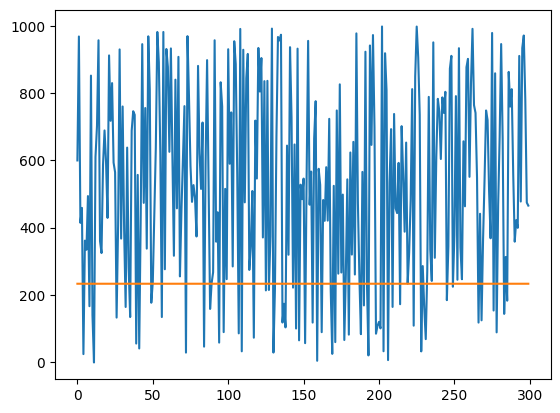

In [26]:
plt.plot(y_ts)
plt.plot(preds)

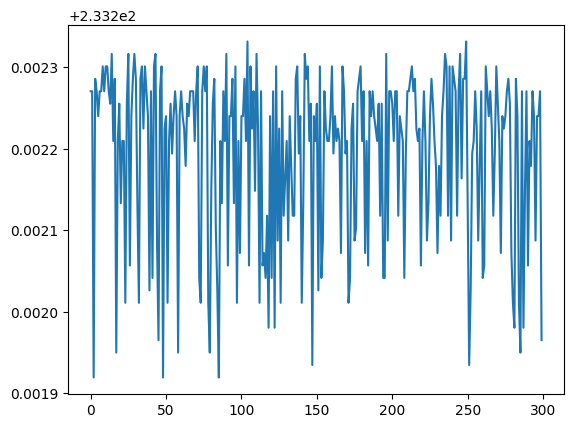

predicted_value = (max_value_norm + 1) / 2 * (max_value - min_value) + min_value

----

In [ ]:
import tensorflow as tf
import numpy as np

def get_data():
    # Generate example data
    np.random.seed(123)
    X = np.random.randn(1000, 6)
    y = np.random.randn(1000, 1)
    return X, y

def physics_loss(pred_y, y, pred_dy_dx, X):
    # Define physics loss
    physics_loss = tf.reduce_mean(tf.square(pred_dy_dx + 0.5 * X[:,0:1] - X[:,1:2] * X[:,5:6] - X[:,3:4] + X[:,4:5] - pred_y))
    return physics_loss

class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense = tf.keras.layers.Dense(64, activation='tanh')
        self.dense_1 = tf.keras.layers.Dense(64, activation='tanh')
        self.dense_2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense(inputs)
        x = self.dense_1(x)
        return self.dense_2(x)



In [ ]:
# Get example data
X, y = get_data()
X = tf.convert_to_tensor(X, dtype=tf.float32)

# Define model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam()

# Training loop
for i in range(1000):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        pred_y = model(X)
        pred_dy_dx = tape.gradient(pred_y, X)
        loss = physics_loss(pred_y, y, pred_dy_dx, X)

    # Compute gradients and update variables
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Print loss every 100 iterations
    if i % 100 == 0:
        print(f"Loss at step {i}: {loss.numpy()}")


Loss at step 0: 4.784703254699707
Loss at step 100: 0.9860692024230957
Loss at step 200: 0.5899379253387451
Loss at step 300: 0.5292105078697205
Loss at step 400: 0.5075728893280029
Loss at step 500: 0.4949820041656494
Loss at step 600: 0.48537150025367737
Loss at step 700: 0.4773311913013458
Loss at step 800: 0.47039794921875
Loss at step 900: 0.46378564834594727


----